<center><h1>Brain Tumor</h1><center>


# Libraries


In [1]:
import pandas as pd  # Pandas for reading files 
import numpy as np  # Numpy for math

import seaborn as sns 
import matplotlib.pyplot as plt # Seaborn,Plotly and matplotlib for plotting and visualization
plt.style.use('default') # Set the global style

# Reading the Data

In [2]:
Data_Brain_Tumor = pd.read_csv('Brain Tumor.csv')
Data_Brain_Tumor.replace([np.inf, -np.inf], np.nan, inplace=True)

In [3]:
Data_Brain_Tumor.info() # Information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image               3762 non-null   object 
 1   Class               3762 non-null   int64  
 2   Mean                3762 non-null   float64
 3   Variance            3762 non-null   float64
 4   Standard Deviation  3762 non-null   float64
 5   Entropy             3762 non-null   float64
 6   Skewness            3762 non-null   float64
 7   Kurtosis            3762 non-null   float64
 8   Contrast            3762 non-null   float64
 9   Energy              3762 non-null   float64
 10  ASM                 3762 non-null   float64
 11  Homogeneity         3762 non-null   float64
 12  Dissimilarity       3762 non-null   float64
 13  Correlation         3762 non-null   float64
 14  Coarseness          3762 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 441.0

# Understanding the data with visualizations

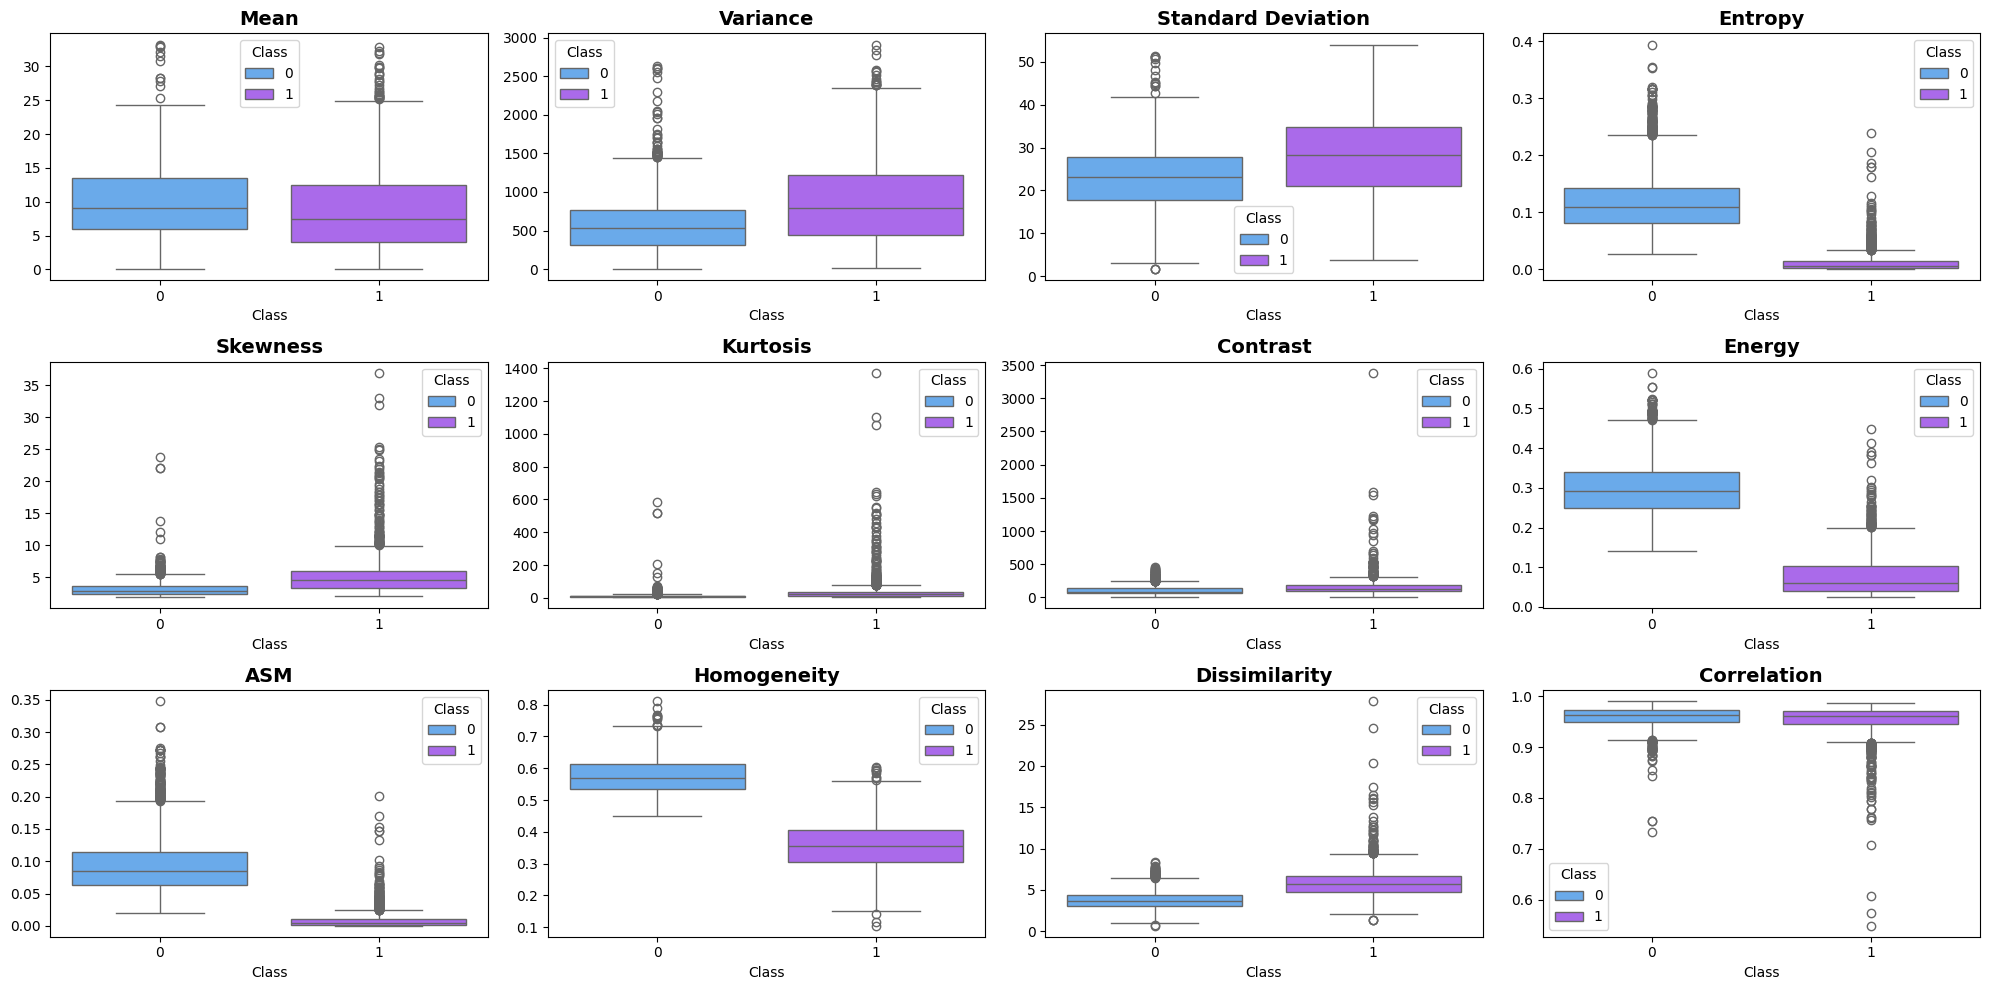

In [4]:
Columns =list(Data_Brain_Tumor.columns)[2:-1]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
axs = axs.flatten()
for idx, column in enumerate(Columns):
    sns.boxplot(x="Class", y=column, data=Data_Brain_Tumor, hue="Class", ax=axs[idx], palette="cool")
    axs[idx].set_title(column, fontsize=14, fontweight='bold')
    axs[idx].set_ylabel('') 

plt.tight_layout()
plt.show()

<Axes: >

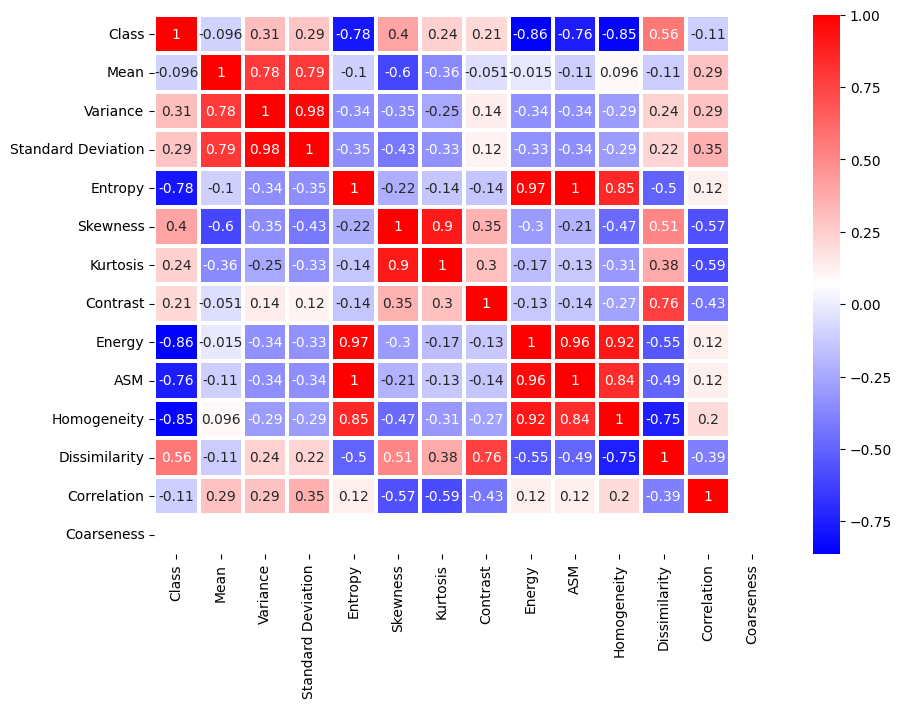

In [5]:
plt.figure(figsize=(10,7))
sns.heatmap(Data_Brain_Tumor.drop("Image",axis=1).corr(), annot=True, cmap="bwr", linewidths=1.5)

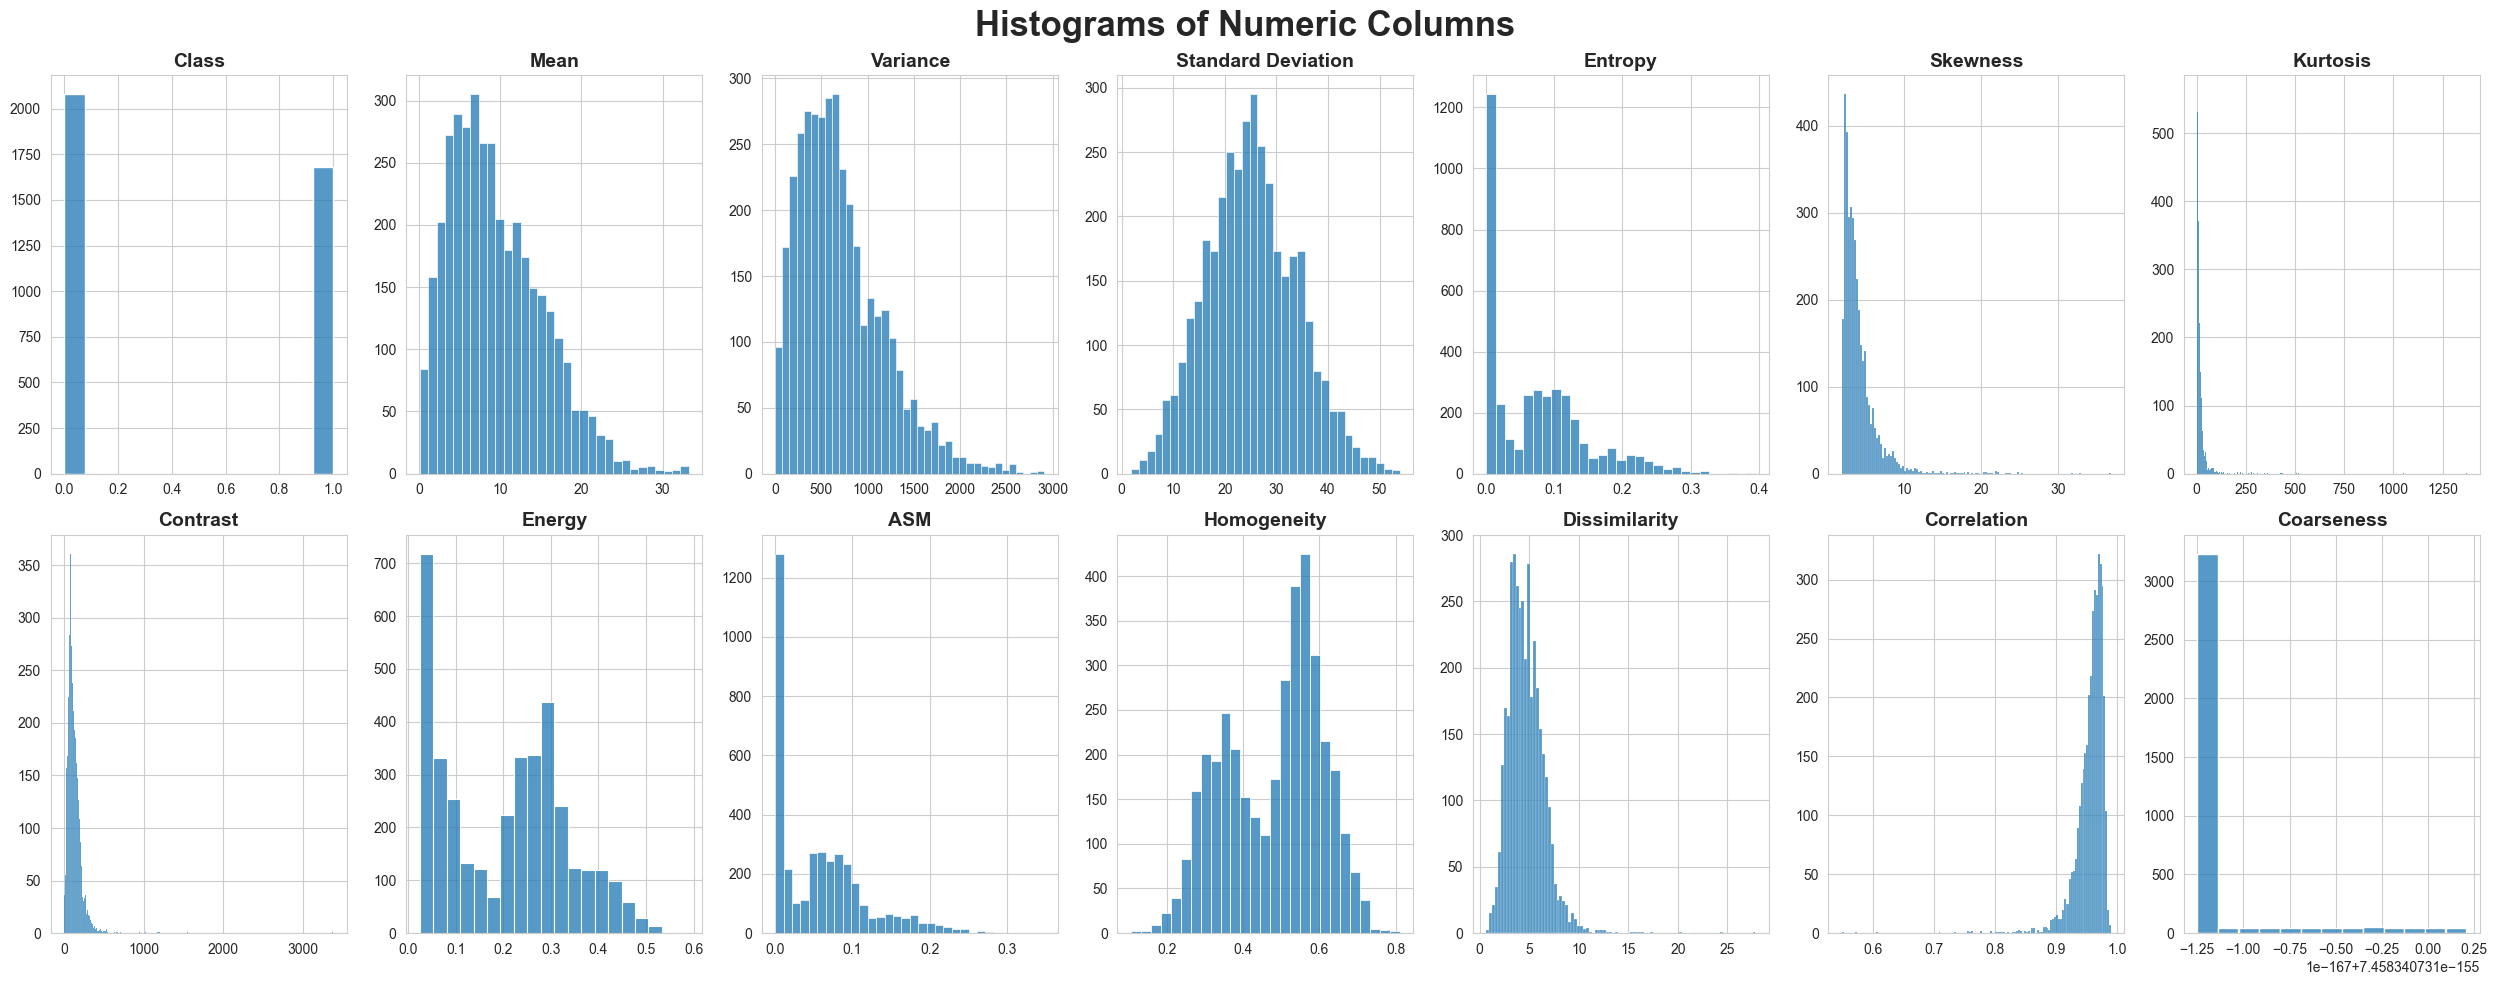

In [6]:
sns.set_style('whitegrid')

columns = Data_Brain_Tumor.select_dtypes(include='number').columns
fig, axs = plt.subplots(nrows=2, ncols=7, figsize=(25, 10))

axs = axs.flatten()

for idx, column in enumerate(columns):
    sns.histplot(Data_Brain_Tumor[column], kde=False, ax=axs[idx]) #type:ignore
    axs[idx].set_title(column, fontsize=14, fontweight="bold")
    axs[idx].set_ylabel('') 
    axs[idx].set_xlabel('') 

# Add a title to the plot
plt.suptitle('Histograms of Numeric Columns', fontsize=25, fontweight="bold")

# Hide any unused subplots
for ax in axs[len(columns):]:
    ax.set_visible(False)

# Adjust the layout and display the plots
plt.tight_layout()

plt.show()

In [7]:
from PIL import Image

In [8]:
def show_img(image_name:str,ax):  # Function to show images in specific axis
    img = plt.imread(f"Brain Tumor/{image_name}")
    ax.imshow(img)
    ax.axis(False)
def Show_NM_Images(n,m=None): # Function to show n*m images
    m=n if m is None else m
    fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(20, 20))
    for i in range(n):
        for j in range(m):
            show_img(f"Image{i*n+j+1}.jpg",axs[i,j])

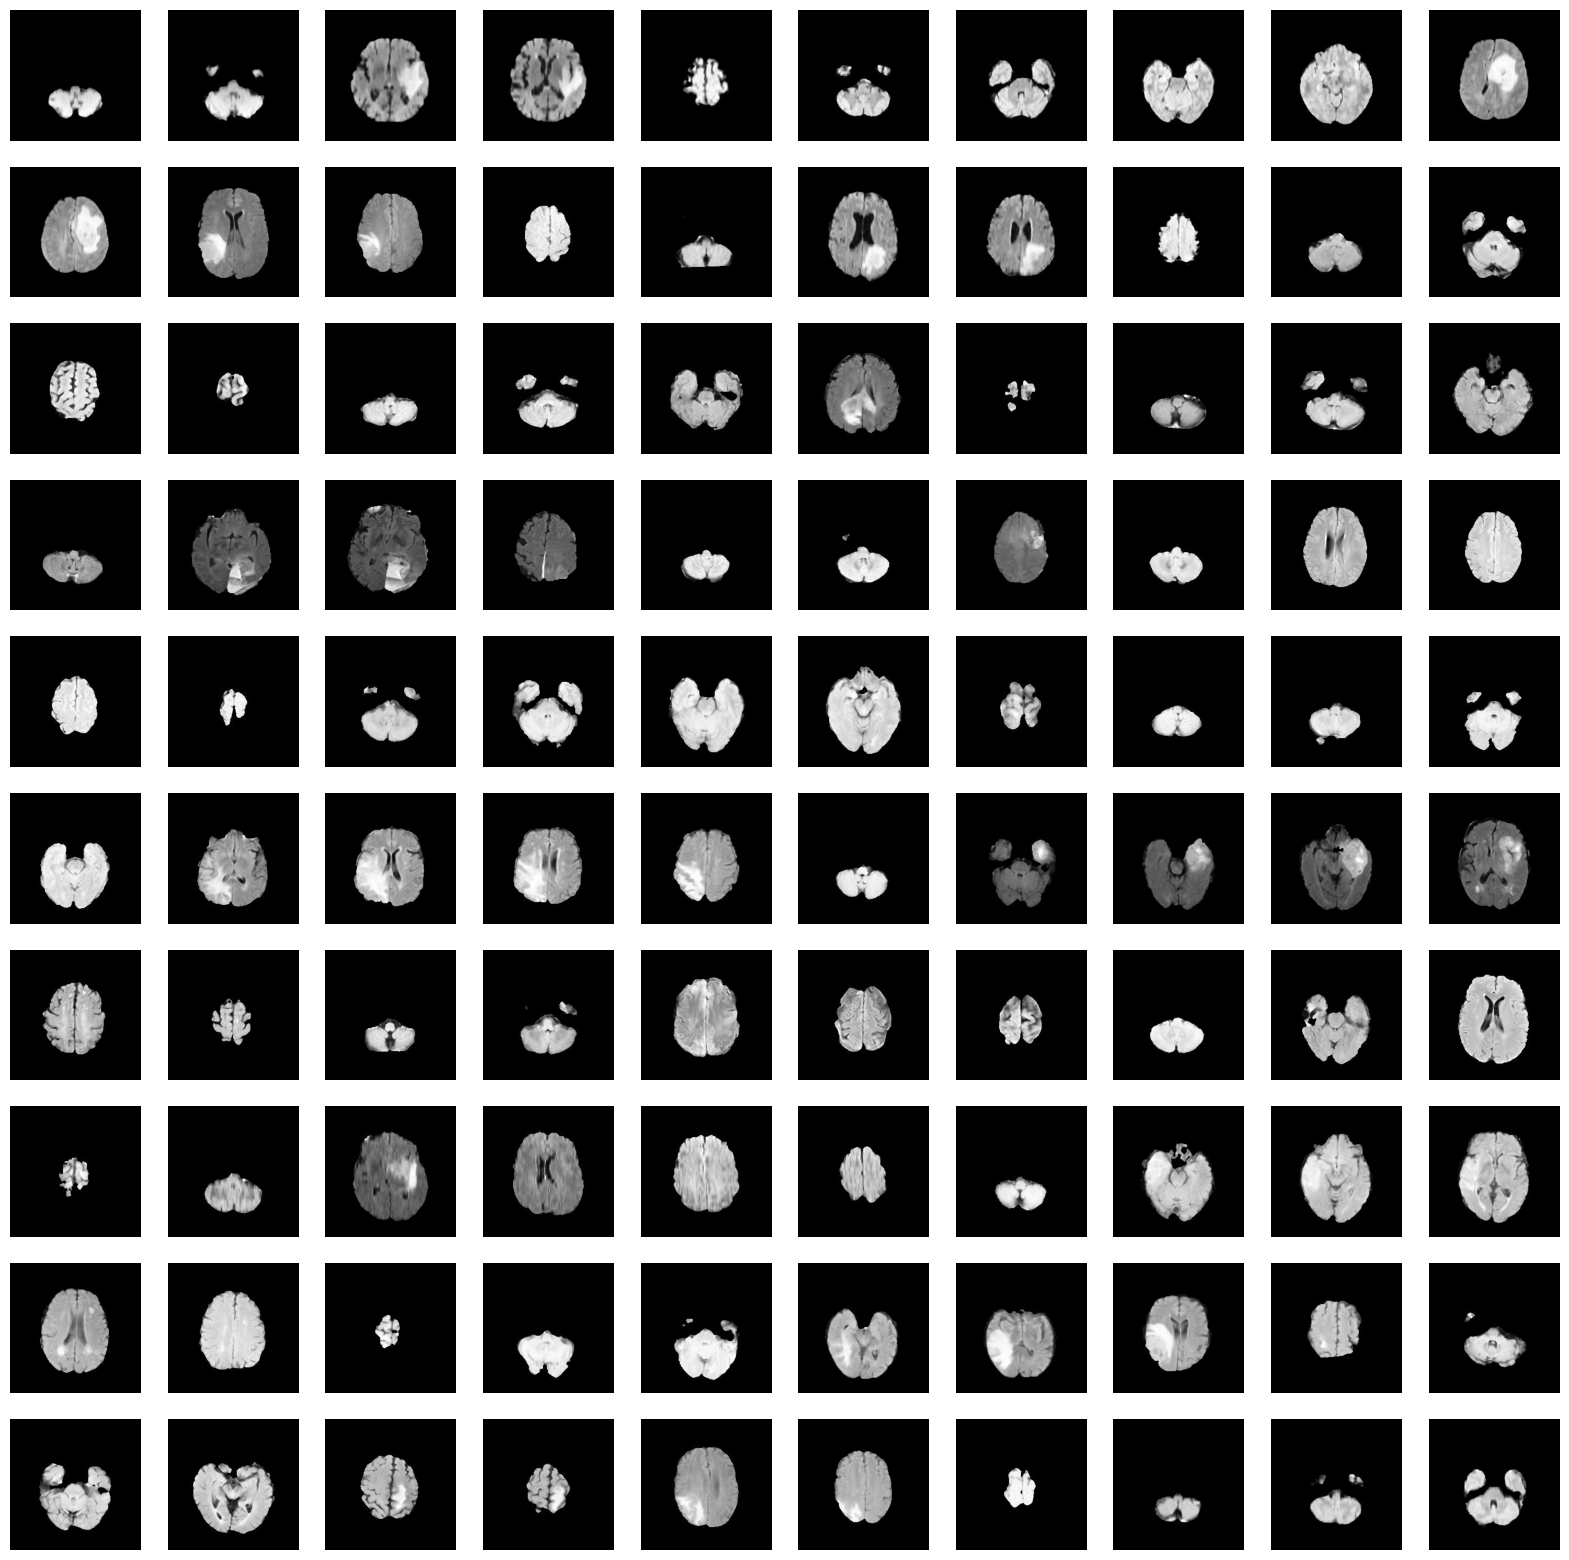

In [9]:
Show_NM_Images(10)

In [10]:
# making the image column to paths for jpg images
Data_Brain_Tumor["Imagejpg"] = Data_Brain_Tumor["Image"].apply(
    lambda x: f"Brain Tumor/{x}.jpg"
)

# Function to convert image to array
def image_to_array(image_path):
    with Image.open(image_path) as img:
        return np.array(img)

In [11]:
Data_Brain_Tumor['Imagejpg'] = Data_Brain_Tumor['Imagejpg'].apply(image_to_array)#type:ignore
Data_Brain_Tumor.drop("Image",axis=1,inplace=True)

In [12]:
Data_Brain_Tumor["Imagejpg"][0].shape

(240, 240, 3)

# Modeling

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model  # type:ignore
from tensorflow.keras.layers import (  # type:ignore
    Dense,
    Conv2D,
    Flatten,
    MaxPooling2D,
    Dropout,
    Input,
    concatenate,
)


from sklearn.model_selection import train_test_split

In [35]:
# Creating the first part of the model to extract features from images
base_model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=(240, 240, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        Flatten(),
    ]
)

base_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [36]:
Training_Data , Testing_Data = train_test_split(Data_Brain_Tumor, train_size=0.8, random_state=42,stratify=Data_Brain_Tumor["Class"])

In [37]:
# Extracting features from Data set (80% of the data)
additional_params_np = Training_Data.drop(["Class","Imagejpg"],axis=1).to_numpy()

In [ ]:
additional_input = Input(shape=(additional_params_np.shape[1],))

# Concatenate base model output with additional input
combined_input = concatenate([base_model.output, additional_input]) #type:ignore
x = Dense(64, activation="relu")(combined_input)
output = Dense(1, activation="sigmoid")(x)
combined_model = Model(inputs=[base_model.input, additional_input], outputs=output)

# Compile the combined model
combined_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

In [38]:
print(type(Data_Brain_Tumor["Imagejpg"]), Data_Brain_Tumor["Imagejpg"].shape)
print(type(additional_params_np), additional_params_np.shape)
print(type(Data_Brain_Tumor["Class"]), Data_Brain_Tumor["Class"].shape)

<class 'pandas.core.series.Series'> (3762,)
<class 'numpy.ndarray'> (3009, 13)
<class 'pandas.core.series.Series'> (3762,)


### Now we fit the data

In [ ]:
History = base_model.fit(
    [
        np.stack(Training_Data["Imagejpg"].values).astype("float32") / 255.0,
        additional_params_np,
    ],
    Training_Data["Class"].values,
    epochs=3,
    batch_size=32,
    verbose=1,
)

Epoch 1/3
95/95 [==============================] - 174s 2s/step - loss: 0.3579 - accuracy: 0.8674
Epoch 2/3
95/95 [==============================] - 173s 2s/step - loss: 0.1799 - accuracy: 0.9408
Epoch 3/3
54/95 [================>.............] - ETA: 1:15 - loss: 0.1077 - accuracy: 0.9595

In [ ]:
history_dict = History.history

# Plot the training and validation loss
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

axs[0].plot(history_dict['loss'], label='Training Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and validation accuracy
axs[1].plot(history_dict['accuracy'], label='Training Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [43]:
additional_params_np2 = Testing_Data.drop(["Class", "Imagejpg"], axis=1).to_numpy()

In [ ]:
base_model.evaluate([np.stack(Testing_Data["Imagejpg"].values).astype('float32') / 255.0, additional_params_np2], Testing_Data["Class"].values)

In [ ]:
base_model.save("Brain_Tumor.h5")  # Save the model

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [46]:
std_scaler = StandardScaler()

X_train_scale = std_scaler.fit_transform(additional_params_np)
X_test_scale = std_scaler.fit_transform(additional_params_np2)

X_train_scale.shape, X_test_scale.shape

((3009, 13), (753, 13))

In [47]:
param_grid = {
    "n_neighbors": [1, 3],
    "algorithm": ["auto","kd_tree"],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "weights": ["uniform", "distance"],
    "leaf_size": [10, 20, 30],
    "p": [1, 2],
    "n_jobs": [-1]  # Use all cores
}
knn_model = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_scale, Training_Data["Class"])

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated score: {grid_search.best_score_}")

best_knn_model = grid_search.best_estimator_


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best cross-validated score: 0.9870404254260616


In [48]:
y_pred = best_knn_model.predict(X_test_scale)

acc = accuracy_score(Testing_Data["Class"], y_pred)
print(f"KNN model accuracy: {acc}")

KNN model accuracy: 0.9907038512616202


In [49]:
print(classification_report(y_pred, Testing_Data["Class"]))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       421
           1       0.98      1.00      0.99       332

    accuracy                           0.99       753
   macro avg       0.99      0.99      0.99       753
weighted avg       0.99      0.99      0.99       753



In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["log2", "sqrt"]
}

Tree = DecisionTreeClassifier() 

# Create the GridSearchCV object
grid_search = GridSearchCV(Tree, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(additional_params_np, Training_Data["Class"])

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated score: {grid_search.best_score_}")

best_Tree = grid_search.best_estimator_


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validated score: 0.9830509505198975


In [52]:
y_pred = best_Tree.predict(additional_params_np2)

acc = accuracy_score(Testing_Data["Class"], y_pred)
print(f"DecisionTree model accuracy: {acc}")

DecisionTree model accuracy: 0.9814077025232404


In [53]:
print(classification_report(y_pred, Testing_Data["Class"]))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       428
           1       0.96      1.00      0.98       325

    accuracy                           0.98       753
   macro avg       0.98      0.98      0.98       753
weighted avg       0.98      0.98      0.98       753



In [54]:
from sklearn.tree import plot_tree

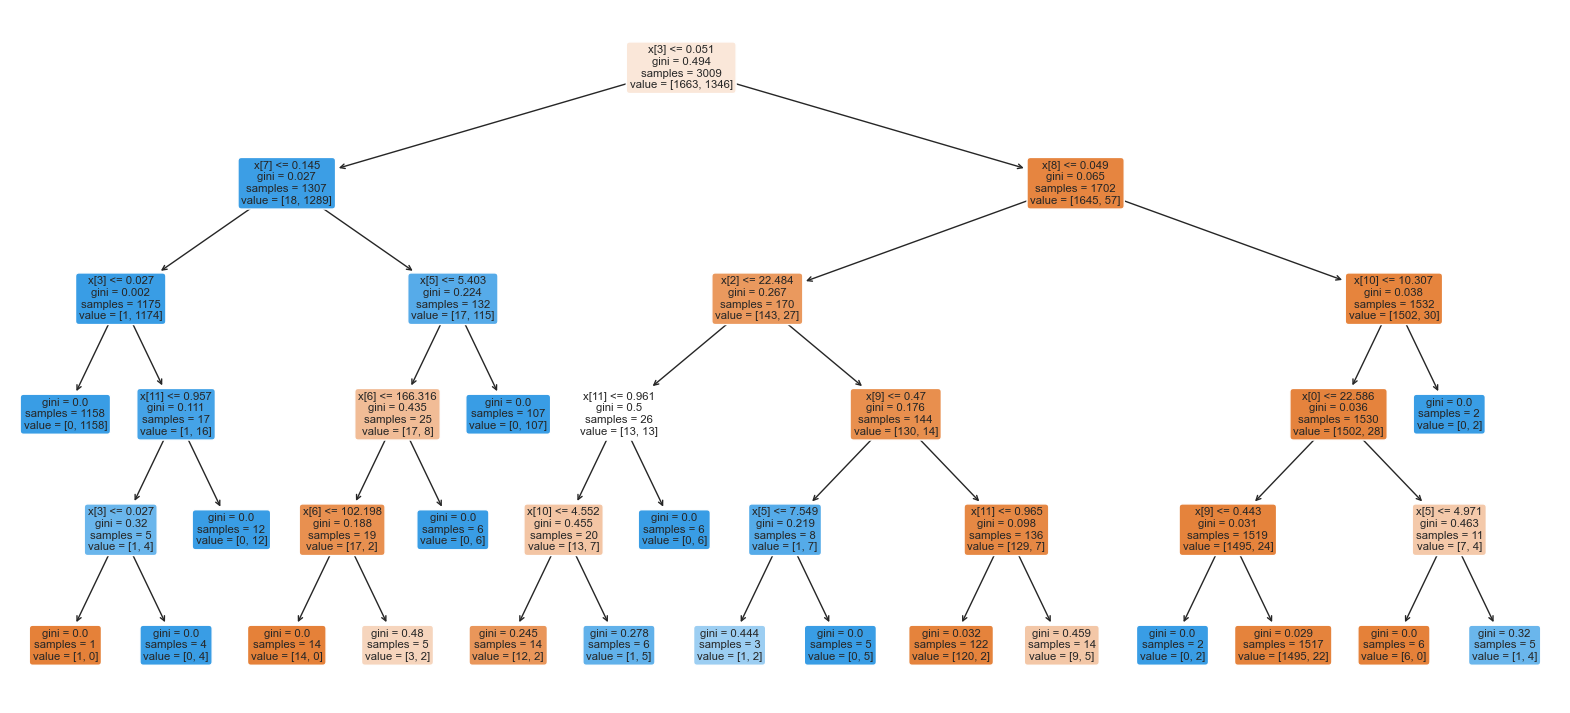

In [55]:
plt.figure(figsize=(20, 9))
plot_tree(best_Tree, filled=True, rounded=True)
plt.show()